In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import warnings
import time
import itertools
warnings.filterwarnings('ignore')

In [3]:
officers_only = pd.read_csv('officers_only.csv')
officers_only = officers_only.drop(columns = 'Unnamed: 0')
df = officers_only[officers_only['sustained'] ==1]

In [4]:
# unit_description dummy df
unit_df = (pd.get_dummies(df['unit_description'])).astype(float)
unit_df = unit_df.drop(columns='Unknown')

# complaint_category dummy df
complaint_df = (pd.get_dummies(df['complaint_category'])).astype(float)
complaint_df = complaint_df.drop(columns='Other')

# officer gender dummy 
gender_df = pd.get_dummies(df['officer_gender'])

# drop female (only need 1 dummy to encode binary)
gender_df = gender_df.drop(columns='FEMALE')
# officer Race dummy 
race_df = pd.get_dummies(df['officer_race'])
race_df.columns = race_df.columns.str.replace('/','_')

# on off duty dummy
duty_df = pd.get_dummies(df['on_off_duty'])
# Drop OFF dummy (only need 1 to encode binary)
duty_df = duty_df.drop(columns='OFF')


# Clean up columns
complaint_df.columns = complaint_df.columns.str.replace(' ', '_')
complaint_df.columns = complaint_df.columns.str.replace('/', '_')
complaint_df.columns = complaint_df.columns.str.replace(')', '')
complaint_df.columns = complaint_df.columns.str.replace('(', '_')
complaint_df.columns = complaint_df.columns.str.replace('-', '_')

unit_df.columns = unit_df.columns.str.replace(' ', '_')
unit_df.columns = unit_df.columns.str.replace('-', '_')
unit_df.columns = unit_df.columns.str.replace('(', '')
unit_df.columns = unit_df.columns.str.replace(')', '')
unit_df.columns = unit_df.columns.str.replace('.', '')
unit_df.columns = unit_df.columns.str.replace('&', '_')

In [5]:
full_df = pd.concat([unit_df,complaint_df,gender_df,race_df,duty_df], axis=1)
full_df['disciplined'] = df['disciplined']
full_df['age'] = df['officer_age']
full_df['salary'] = df['salary']

In [12]:
X = full_df[['ADMIN_SCHOOL_SECURIT', 'AIRPORT_RELATED', 'BOMB_AND_ARSON_DIVISION',
       'BUREAU_OF_INTERNAL_AFFAIRS', 'BUREAU_OF_ORGANIZED_CRIME',
       'CENTRAL_DETENTION_UNIT', 'CENTRAL_INVESTIGATIONS_DIVISION',
       'DET_DIV_ADMIN', 'DETACHED_SERVICES___GOVERMENT_SECURITY',
       'DETACHED_SERVICES___MISCELLANEOUS_DETAIL', 'DETECTIVE_AREA___CENTRAL',
       'DETECTIVE_AREA___NORTH', 'DETECTIVE_AREA___SOUTH',
       'DETECTIVE_SECTION___AREA_4', 'DETECTIVE_SECTION___AREA_5',
       'DISTRICT_001', 'DISTRICT_002', 'DISTRICT_003', 'DISTRICT_004',
       'DISTRICT_005', 'DISTRICT_006', 'DISTRICT_007', 'DISTRICT_008',
       'DISTRICT_009', 'DISTRICT_010', 'DISTRICT_011', 'DISTRICT_012',
       'DISTRICT_013', 'DISTRICT_014', 'DISTRICT_015', 'DISTRICT_016',
       'DISTRICT_017', 'DISTRICT_018', 'DISTRICT_019', 'DISTRICT_020',
       'DISTRICT_021', 'DISTRICT_022', 'DISTRICT_023', 'DISTRICT_024',
       'DISTRICT_025', 'DISTRICT_REINSTATEMENT_UNIT',
       'EDUCATION_AND_TRAINING_DIVISION', 'FIELD_SERVICES_SECTION', 'FORENSIC',
       'GANG_ENFORCEMENT_INVESTIGATION', 'HUMAN_RESOURCES_DIVISION',
       'INSPECTION_DIVISION', 'INTELLIGENCE_SECTION',
       'MAJOR_ACCIDENT_INVESTIGATION_UNIT', 'MARINE_OPERATIONS_UNIT',
       'MOBILE_STRIKE_FORCE', 'MOUNTED_UNIT', 'NARCOTICS_DIVISION',
       'OEMC___DETAIL_SECTION', 'OFFICE_OF_THE_FIRST_DEPUTY_SUPERINTENDENT',
       'Other', 'PATROL', 'POLICE_DOCUMENTS_SECTION', 'PREVEN___NEIGH_DIV',
       'PROPERTY_RELATED', 'PUBLIC_HOUSING', 'PUBLIC_TRANSPORTATION_SECTION',
       'RECRUIT_TRAINING_SECTION', 'SPECIAL_INVESTIGATIONS_UNIT',
       'SPECIAL_WEAPONS_AND_TACTICS_SWAT_UNIT', 'TRAFFIC_RELATED',
       'YOUTH_JUVENILE', 'Bribery___Official_Corruption',
       'Conduct_Unbecoming__Off_duty', 'Criminal_Misconduct', 'Domestic',
       'Drug___Alcohol_Abuse', 'False_Arrest', 'Illegal_Search',
       'Lockup_Procedures', 'Operation_Personnel_Violations',
       'Supervisory_Responsibilities', 'Traffic', 'Use_of_Force',
       'Verbal_Abuse', 'MALE', 'ASIA_PAC_NATIV_AM', 'BLACK', 'HISPANIC',
       'WHITE', 'ON','age', 'salary']]

# Forward Selection

In [13]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('disciplined~' + '+'.join(predictor_subset),data = full_df).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [14]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [15]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

In [16]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
    plt.subplot(2, 2, 1)

    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')


    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [17]:
models_best = forward_selection()

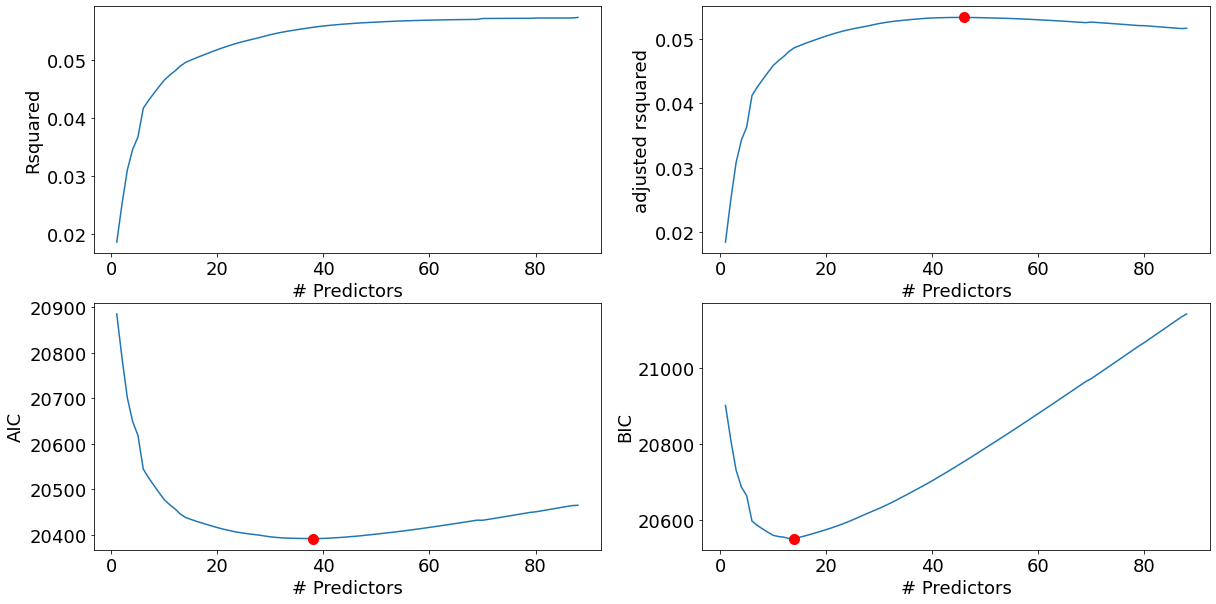

In [18]:
best_sub_plots()

In [19]:
best_fwd_reg_model = models_best['model'][38]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            disciplined   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     22.84
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          1.24e-152
Time:                        09:29:21   Log-Likelihood:                -10157.
No. Observations:               14797   AIC:                         2.039e+04
Df Residuals:                   14758   BIC:                         2.069e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.4620      0.026     17.490      0.000       0.410       0.514
ON                                  0.0397      0.022      1.769      0.077      -0.004       0.084
Use_of_Force                        0.2354      0.017     13.763      0.000       0.202       0.269
WHITE                              -0.0406      0.012     -3.366      0.001      -0.064      -0.017
Domestic                            0.1861      0.025      7.464      0.000       0.137       0.235
Conduct_Unbecoming__Off_duty        0.2265      0.026      8.668      0.000       0.175       0.278
Drug___Alcohol_Abuse                0.2610      0.031      8.286      0.000       0.199       0.323
OEMC___DETAIL_SECTION              -0.1992      0.042     -4.786      0.000      -0.281      -0.118
MOBILE_STRIKE_FORCE                -0.2611      0.062     -4.216      0.000      -0.382      -0.140
Criminal_Misconduct                -0.1051      0.023     -4.559      0.000      -0.150      -0.060
Supervisory_Responsibilities       -0.1244      0.030     -4.116      0.000      -0.184      -0.065
Bribery___Official_Corruption       0.2188      0.062      3.509      0.000       0.097       0.341
BLACK                               0.0581      0.012      4.713      0.000       0.034       0.082
DISTRICT_003                       -0.0775      0.022     -3.579      0.000      -0.120      -0.035
DETECTIVE_SECTION___AREA_4         -0.2270      0.074     -3.081      0.002      -0.371      -0.083
MALE                                0.0231      0.010      2.348      0.019       0.004       0.042
Illegal_Search                     -0.0940      0.040     -2.337      0.019      -0.173      -0.015
HUMAN_RESOURCES_DIVISION           -0.1903      0.082     -2.332      0.020      -0.350      -0.030
GANG_ENFORCEMENT_INVESTIGATION     -0.0985      0.044     -2.224      0.026      -0.185      -0.012
DISTRICT_007                       -0.0486      0.023     -2.125      0.034      -0.093      -0.004
RECRUIT_TRAINING_SECTION            0.1602      0.067      2.405      0.016       0.030       0.291
DISTRICT_022                       -0.0383      0.021     -1.820      0.069      -0.079       0.003
Verbal_Abuse                        0.0674      0.032      2.131      0.033       0.005       0.129
MOUNTED_UNIT                       -0.1866      0.091     -2.048      0.041      -0.365      -0.008
DISTRICT_019                        0.0534      0.022      2.396      0.017       0.010       0.097
DISTRICT_021                       -0.0781      0.044     -1.773      0.076      -0.165       0.008
DISTRICT_023                       -0.0957      0.056     -1.723      0.085      -0.204       0.013
DETECTIVE_AREA___NORTH              0.0591      0.028      2.121      0.034       0

In [20]:
best_fwd_reg_model2 = models_best['model'][47]
best_fwd_reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            disciplined   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     18.72
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          4.00e-149
Time:                        09:29:30   Log-Likelihood:                -10151.
No. Observations:               14797   AIC:                         2.040e+04
Df Residuals:                   14749   BIC:                         2.076e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.4642      0.027     17.491      0.000       0.412       0.516
ON                                           0.0393      0.022      1.749      0.080      -0.005       0.083
Use_of_Force                                 0.2329      0.017     13.525      0.000       0.199       0.267
WHITE                                       -0.0402      0.012     -3.331      0.001      -0.064      -0.017
Domestic                                     0.1845      0.025      7.381      0.000       0.136       0.234
Conduct_Unbecoming__Off_duty                 0.2245      0.026      8.567      0.000       0.173       0.276
Drug___Alcohol_Abuse                         0.2591      0.032      8.212      0.000       0.197       0.321
OEMC___DETAIL_SECTION                       -0.1996      0.042     -4.785      0.000      -0.281      -0.118
MOBILE_STRIKE_FORCE                         -0.2614      0.062     -4.219      0.000      -0.383      -0.140
Criminal_Misconduct                         -0.1052      0.023     -4.543      0.000      -0.151      -0.060
Supervisory_Responsibilities                -0.1260      0.030     -4.159      0.000      -0.185      -0.067
Bribery___Official_Corruption                0.2165      0.062      3.470      0.001       0.094       0.339
BLACK                                        0.0565      0.012      4.549      0.000       0.032       0.081
DISTRICT_003                                -0.0760      0.022     -3.485      0.000      -0.119      -0.033
DETECTIVE_SECTION___AREA_4                  -0.2267      0.074     -3.075      0.002      -0.371      -0.082
MALE                                         0.0226      0.010      2.301      0.021       0.003       0.042
Illegal_Search                              -0.0982      0.040     -2.438      0.015      -0.177      -0.019
HUMAN_RESOURCES_DIVISION                    -0.1889      0.082     -2.314      0.021      -0.349      -0.029
GANG_ENFORCEMENT_INVESTIGATION              -0.0970      0.044     -2.190      0.029      -0.184      -0.010
DISTRICT_007                                -0.0463      0.023     -2.016      0.044      -0.091      -0.001
RECRUIT_TRAINING_SECTION                     0.1605      0.067      2.408      0.016       0.030       0.291
DISTRICT_022                                -0.0371      0.021     -1.755      0.079      -0.078       0.004
Verbal_Abuse                                 0.0665      0.032      2.097      0.036       0.004       0.129
MOUNTED_UNIT                                -0.1862      0.091     -2.043      0.041      -0.365      -0.008
DISTRICT_019                                 0.0535      0.022      2.392      0.017       0.010       0.097
DISTRICT_021                   

In [21]:
best_fwd_reg_model3 = models_best['model'][14]
best_fwd_reg_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            disciplined   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     55.00
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          3.38e-151
Time:                        09:29:37   Log-Likelihood:                -10204.
No. Observations:               14797   AIC:                         2.044e+04
Df Residuals:                   14782   BIC:                         2.055e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4891      0.025     19.687      0.000       0.440       0.538
ON                                0.0412      0.022      1.830      0.067      -0.003       0.085
Use_of_Force                      0.2395      0.017     14.047      0.000       0.206       0.273
WHITE                            -0.0443      0.012     -3.730      0.000      -0.068      -0.021
Domestic                          0.1874      0.025      7.521      0.000       0.139       0.236
Conduct_Unbecoming__Off_duty      0.2299      0.026      8.787      0.000       0.179       0.281
Drug___Alcohol_Abuse              0.2714      0.031      8.632      0.000       0.210       0.333
OEMC___DETAIL_SECTION            -0.2066      0.042     -4.975      0.000      -0.288      -0.125
MOBILE_STRIKE_FORCE              -0.2706      0.062     -4.368      0.000      -0.392      -0.149
Criminal_Misconduct              -0.1004      0.023     -4.358      0.000      -0.146      -0.055
Supervisory_Responsibilities     -0.1275      0.030     -4.216      0.000      -0.187      -0.068
Bribery___Official_Corruption     0.2246      0.062      3.595      0.000       0.102       0.347
BLACK                             0.0446      0.012      3.764      0.000       0.021       0.068
DISTRICT_003                     -0.0784      0.022     -3.643      0.000      -0.121      -0.036
DETECTIVE_SECTION___AREA_4       -0.2300      0.074     -3.117      0.002      -0.375      -0.085
==============================================================================
Omnibus:                    62032.798   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2024.773
Skew:                          -0.265   Prob(JB):                         0.00
Kurtosis:                       1.267   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Finding Shared Predictors

In [22]:
predictors_1 = set(best_fwd_reg_model.params.index)
predictors_2 = set(best_fwd_reg_model2.params.index)
predictors_3 = set(best_fwd_reg_model3.params.index)

shared_predictors = predictors_1.intersection(predictors_2, predictors_3)
shared_predictors

{'BLACK',
 'Bribery___Official_Corruption',
 'Conduct_Unbecoming__Off_duty',
 'Criminal_Misconduct',
 'DETECTIVE_SECTION___AREA_4',
 'DISTRICT_003',
 'Domestic',
 'Drug___Alcohol_Abuse',
 'Intercept',
 'MOBILE_STRIKE_FORCE',
 'OEMC___DETAIL_SECTION',
 'ON',
 'Supervisory_Responsibilities',
 'Use_of_Force',
 'WHITE'}

# Model with the Shared Predictors

In [23]:
logit_model_shared = smf.logit(formula = 'disciplined~BLACK+Bribery___Official_Corruption+Criminal_Misconduct+DETECTIVE_SECTION___AREA_4+DISTRICT_003+Domestic+Drug___Alcohol_Abuse+MOBILE_STRIKE_FORCE+ON+Supervisory_Responsibilities+Use_of_Force+WHITE', data=full_df).fit()
logit_model_shared.summary()

Optimization terminated successfully.
         Current function value: 0.659991
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            disciplined   No. Observations:                14797
Model:                          Logit   Df Residuals:                    14784
Method:                           MLE   Df Model:                           12
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.03285
Time:                        09:30:46   Log-Likelihood:                -9765.9
converged:                       True   LL-Null:                       -10098.
Covariance Type:            nonrobust   LLR p-value:                3.113e-134
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.7319      0.064     11.433      0.000       0.606       0.857
BLACK                             0.1788      0.051      3.513      0.000       0.079       0.279
Bribery___Official_Corruption     0.9862      0.300      3.292      0.001       0.399       1.573
Criminal_Misconduct              -0.4305      0.097     -4.447      0.000      -0.620      -0.241
DETECTIVE_SECTION___AREA_4       -1.0064      0.342     -2.944      0.003      -1.676      -0.336
DISTRICT_003                     -0.3109      0.091     -3.414      0.001      -0.489      -0.132
Domestic                          0.7926      0.115      6.897      0.000       0.567       1.018
Drug___Alcohol_Abuse              0.6858      0.135      5.062      0.000       0.420       0.951
MOBILE_STRIKE_FORCE              -1.1828      0.291     -4.061      0.000      -1.754      -0.612
ON                               -0.5868      0.052    -11.320      0.000      -0.688      -0.485
Supervisory_Responsibilities     -0.5371      0.129     -4.158      0.000      -0.790      -0.284
Use_of_Force                      0.6956      0.063     10.955      0.000       0.571       0.820
WHITE                            -0.1928      0.051     -3.800      0.000      -0.292      -0.093
=================================================================================================
"""

# Shared Predictors, Age, Salary

In [24]:
logit_model_sharedas = smf.logit(formula = 'disciplined~BLACK+Bribery___Official_Corruption+Criminal_Misconduct+DETECTIVE_SECTION___AREA_4+DISTRICT_003+Domestic+Drug___Alcohol_Abuse+MOBILE_STRIKE_FORCE+ON+Supervisory_Responsibilities+Use_of_Force+WHITE+age+salary', data=full_df).fit()
logit_model_sharedas.summary()

Optimization terminated successfully.
         Current function value: 0.659970
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            disciplined   No. Observations:                14797
Model:                          Logit   Df Residuals:                    14782
Method:                           MLE   Df Model:                           14
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.03288
Time:                        09:31:36   Log-Likelihood:                -9765.6
converged:                       True   LL-Null:                       -10098.
Covariance Type:            nonrobust   LLR p-value:                1.281e-132
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.8106      0.126      6.441      0.000       0.564       1.057
BLACK                             0.1861      0.052      3.595      0.000       0.085       0.288
Bribery___Official_Corruption     0.9889      0.300      3.301      0.001       0.402       1.576
Criminal_Misconduct              -0.4273      0.097     -4.409      0.000      -0.617      -0.237
DETECTIVE_SECTION___AREA_4       -0.9894      0.342     -2.889      0.004      -1.661      -0.318
DISTRICT_003                     -0.3145      0.091     -3.447      0.001      -0.493      -0.136
Domestic                          0.7881      0.115      6.849      0.000       0.563       1.014
Drug___Alcohol_Abuse              0.6825      0.136      5.034      0.000       0.417       0.948
MOBILE_STRIKE_FORCE              -1.1830      0.291     -4.061      0.000      -1.754      -0.612
ON                               -0.5873      0.052    -11.328      0.000      -0.689      -0.486
Supervisory_Responsibilities     -0.5282      0.134     -3.953      0.000      -0.790      -0.266
Use_of_Force                      0.6924      0.064     10.880      0.000       0.568       0.817
WHITE                            -0.1872      0.051     -3.651      0.000      -0.288      -0.087
age                              -0.0013      0.002     -0.569      0.570      -0.006       0.003
salary                        -1.942e-07   2.11e-06     -0.092      0.927   -4.32e-06    3.94e-06
=================================================================================================
"""

# Binned Age

In [25]:
full_df['binned_age'] = pd.cut(full_df['age'], bins = pd.qcut(full_df['age'],10,retbins=True)[1])

# Binned Salary

In [44]:
full_df['binned_salary'] = pd.cut(full_df['salary'], bins = pd.qcut(full_df['salary'],10,retbins=True, duplicates='drop')[1])

Optimization terminated successfully.
         Current function value: 0.682216
         Iterations 4
-10094.753002564692


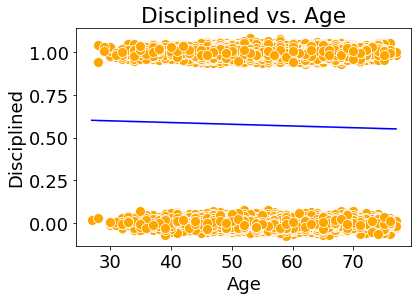

In [37]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = full_df.age, y = jitter(full_df.disciplined,0), data = full_df, color = 'orange')
plt.title('Disciplined vs. Age')
plt.xlabel('Age')
plt.ylabel('Disciplined')
logit_modeljit = smf.logit(formula = 'disciplined~age', data = full_df).fit()
sns.lineplot(x = 'age', y= logit_modeljit.predict(full_df), data = full_df, color = 'blue') 
print(logit_modeljit.llf) #Printing the log likelihood to compare it with the next model we build

Optimization terminated successfully.
         Current function value: 0.682020
         Iterations 4
-10091.854305841885


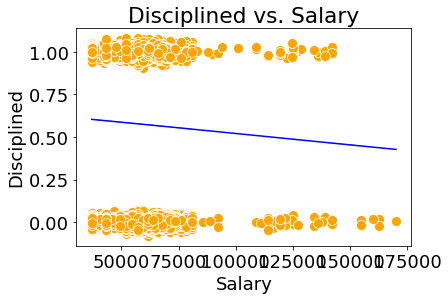

In [39]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = full_df.salary, y = jitter(full_df.disciplined,0), data = full_df, color = 'orange')
plt.title('Disciplined vs. Salary')
plt.xlabel('Salary')
plt.ylabel('Disciplined')
logit_modeljitsal = smf.logit(formula = 'disciplined~salary', data = full_df).fit()
sns.lineplot(x = 'salary', y= logit_modeljitsal.predict(full_df), data = full_df, color = 'blue') 
print(logit_modeljitsal.llf) #Printing the log likelihood to compare it with the next model we build

# Shared Predictors, Binned Age

In [27]:
logit_model_sharedbin = smf.logit(formula = 'disciplined~BLACK+Bribery___Official_Corruption+Criminal_Misconduct+DETECTIVE_SECTION___AREA_4+DISTRICT_003+Domestic+Drug___Alcohol_Abuse+MOBILE_STRIKE_FORCE+ON+Supervisory_Responsibilities+Use_of_Force+WHITE+binned_age+salary', data=full_df).fit()
logit_model_sharedbin.summary()

Optimization terminated successfully.
         Current function value: 0.658784
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            disciplined   No. Observations:                14796
Model:                          Logit   Df Residuals:                    14773
Method:                           MLE   Df Model:                           22
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.03460
Time:                        09:32:33   Log-Likelihood:                -9747.4
converged:                       True   LL-Null:                       -10097.
Covariance Type:            nonrobust   LLR p-value:                1.500e-133
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.7007      0.125      5.596      0.000       0.455       0.946
binned_age[T.Interval(43.0, 47.0, closed='right')]     0.2140      0.076      2.823      0.005       0.065       0.363
binned_age[T.Interval(47.0, 50.0, closed='right')]     0.2718      0.081      3.371      0.001       0.114       0.430
binned_age[T.Interval(50.0, 52.0, closed='right')]     0.1501      0.087      1.717      0.086      -0.021       0.321
binned_age[T.Interval(52.0, 55.0, closed='right')]     0.2387      0.082      2.916      0.004       0.078       0.399
binned_age[T.Interval(55.0, 58.0, closed='right')]     0.2509      0.085      2.959      0.003       0.085       0.417
binned_age[T.Interval(58.0, 61.0, closed='right')]     0.3199      0.088      3.617      0.000       0.147       0.493
binned_age[T.Interval(61.0, 65.0, closed='right')]     0.2083      0.085      2.440      0.015       0.041       0.376
binned_age[T.Interval(65.0, 68.0, closed='right')]    -0.0053      0.094     -0.057      0.955      -0.190       0.179
binned_age[T.Interval(68.0, 77.0, closed='right')]     0.1293      0.092      1.405      0.160      -0.051       0.310
BLACK                                                  0.1726      0.052      3.318      0.001       0.071       0.274
Bribery___Official_Corruption                          1.0039      0.300      3.346      0.001       0.416       1.592
Criminal_Misconduct                                   -0.4179      0.097     -4.306      0.000      -0.608      -0.228
DETECTIVE_SECTION___AREA_4                            -0.9410      0.344     -2.739      0.006      -1.614      -0.268
DISTRICT_003                                          -0.3099      0.091     -3.389      0.001      -0.489      -0.131
Domestic                                               0.7808      0.115      6.778      0.000       0.555       1.007
Drug___Alcohol_Abuse                                   0.6963      0.136      5.130      0.000       0.430       0.962
MOBILE_STRIKE_FORCE                                   -1.1645      0.291     -4.000      0.000      -1.735      -0.594
ON                                                    -0.5842      0.052    -11.250      0.000      -0.686      -0.482
Supervisory_Responsibilities                          -0.4900      0.134     -3.661      0.000      -0.752      -0.228
Use_of_Force                                           0.6971      0.064     10.935      0.000       0.572       0.822
WHITE                                                 -0.1774      0.051     -3.450      0.001      -0.278      -0.077
salary                                             -2.632e-06   2.17e-06     -1.213      0.225   -6.88e-06    1.62e-06
======================================================================================================================
"""

# Log Transformation on Salary

In [41]:
logit_model_sharedlogsal = smf.logit(formula = 'disciplined~BLACK+Bribery___Official_Corruption+Criminal_Misconduct+DETECTIVE_SECTION___AREA_4+DISTRICT_003+Domestic+Drug___Alcohol_Abuse+MOBILE_STRIKE_FORCE+ON+Supervisory_Responsibilities+Use_of_Force+WHITE+binned_age+np.log(salary)', data=full_df).fit()
logit_model_sharedlogsal.summary()

Optimization terminated successfully.
         Current function value: 0.658834
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            disciplined   No. Observations:                14796
Model:                          Logit   Df Residuals:                    14773
Method:                           MLE   Df Model:                           22
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.03452
Time:                        09:48:36   Log-Likelihood:                -9748.1
converged:                       True   LL-Null:                       -10097.
Covariance Type:            nonrobust   LLR p-value:                3.065e-133
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.5427      1.529      0.355      0.723      -2.455       3.540
binned_age[T.Interval(43.0, 47.0, closed='right')]     0.1874      0.078      2.400      0.016       0.034       0.340
binned_age[T.Interval(47.0, 50.0, closed='right')]     0.2373      0.084      2.840      0.005       0.074       0.401
binned_age[T.Interval(50.0, 52.0, closed='right')]     0.1088      0.091      1.194      0.233      -0.070       0.287
binned_age[T.Interval(52.0, 55.0, closed='right')]     0.1951      0.086      2.260      0.024       0.026       0.364
binned_age[T.Interval(55.0, 58.0, closed='right')]     0.2036      0.090      2.274      0.023       0.028       0.379
binned_age[T.Interval(58.0, 61.0, closed='right')]     0.2697      0.093      2.896      0.004       0.087       0.452
binned_age[T.Interval(61.0, 65.0, closed='right')]     0.1546      0.091      1.705      0.088      -0.023       0.332
binned_age[T.Interval(65.0, 68.0, closed='right')]    -0.0650      0.099     -0.653      0.514      -0.260       0.130
binned_age[T.Interval(68.0, 77.0, closed='right')]     0.0678      0.098      0.695      0.487      -0.123       0.259
BLACK                                                  0.1737      0.052      3.341      0.001       0.072       0.276
Bribery___Official_Corruption                          1.0028      0.300      3.341      0.001       0.415       1.591
Criminal_Misconduct                                   -0.4217      0.097     -4.344      0.000      -0.612      -0.231
DETECTIVE_SECTION___AREA_4                            -0.9525      0.344     -2.772      0.006      -1.626      -0.279
DISTRICT_003                                          -0.3057      0.091     -3.342      0.001      -0.485      -0.126
Domestic                                               0.7815      0.115      6.784      0.000       0.556       1.007
Drug___Alcohol_Abuse                                   0.6993      0.136      5.152      0.000       0.433       0.965
MOBILE_STRIKE_FORCE                                   -1.1670      0.291     -4.009      0.000      -1.738      -0.596
ON                                                    -0.5837      0.052    -11.240      0.000      -0.685      -0.482
Supervisory_Responsibilities                          -0.5319      0.133     -4.002      0.000      -0.792      -0.271
Use_of_Force                                           0.6967      0.064     10.930      0.000       0.572       0.822
WHITE                                                 -0.1816      0.051     -3.530      0.000      -0.282      -0.081
np.log(salary)                                         0.0038      0.143      0.027      0.979      -0.276       0.284
======================================================================================================================
"""

# Shared Predictors, Binned Salary & Age

In [56]:
logit_model_sharedbinboth = smf.logit(formula = 'disciplined~BLACK+Bribery___Official_Corruption+Criminal_Misconduct+DETECTIVE_SECTION___AREA_4+DISTRICT_003+Domestic+Drug___Alcohol_Abuse+MOBILE_STRIKE_FORCE+ON+Supervisory_Responsibilities+Use_of_Force+WHITE+binned_age+binned_salary', data=full_df).fit()
logit_model_sharedbinboth.summary()

Optimization terminated successfully.
         Current function value: 0.656932
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            disciplined   No. Observations:                14167
Model:                          Logit   Df Residuals:                    14138
Method:                           MLE   Df Model:                           28
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.03676
Time:                        10:07:33   Log-Likelihood:                -9306.8
converged:                       True   LL-Null:                       -9662.0
Covariance Type:            nonrobust   LLR p-value:                1.312e-131
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        0.5418      0.090      5.988      0.000       0.364       0.719
binned_age[T.Interval(43.0, 47.0, closed='right')]               0.1532      0.092      1.672      0.095      -0.026       0.333
binned_age[T.Interval(47.0, 50.0, closed='right')]               0.1568      0.097      1.622      0.105      -0.033       0.346
binned_age[T.Interval(50.0, 52.0, closed='right')]               0.0079      0.104      0.076      0.940      -0.196       0.211
binned_age[T.Interval(52.0, 55.0, closed='right')]               0.0726      0.100      0.727      0.467      -0.123       0.268
binned_age[T.Interval(55.0, 58.0, closed='right')]               0.0610      0.103      0.592      0.554      -0.141       0.263
binned_age[T.Interval(58.0, 61.0, closed='right')]               0.1304      0.106      1.227      0.220      -0.078       0.339
binned_age[T.Interval(61.0, 65.0, closed='right')]               0.0244      0.104      0.235      0.814      -0.179       0.228
binned_age[T.Interval(65.0, 68.0, closed='right')]              -0.1640      0.111     -1.481      0.139      -0.381       0.053
binned_age[T.Interval(68.0, 77.0, closed='right')]              -0.0276      0.109     -0.252      0.801      -0.242       0.187
binned_salary[T.Interval(49548.0, 57426.0, closed='right')]      0.1297      0.083      1.565      0.117      -0.033       0.292
binned_salary[T.Interval(57426.0, 59412.0, closed='right')]      0.2372      0.096      2.478      0.013       0.050       0.425
binned_salary[T.Interval(59412.0, 61512.0, closed='right')]      0.3500      0.102      3.431      0.001       0.150       0.550
binned_salary[T.Interval(61512.0, 63654.0, closed='right')]      0.2716      0.111      2.453      0.014       0.055       0.489
binned_salary[T.Interval(63654.0, 66006.0, closed='right')]      0.1082      0.109      0.996      0.319      -0.105       0.321
binned_salary[T.Interval(66006.0, 71382.0, closed='right')]      0.1716      0.104      1.653      0.098      -0.032       0.375
binned_salary[T.Interval(71382.0, 170112.0, closed='right')]    -0.0140      0.109     -0.128      0.898      -0.229       0.201
BLACK                                                            0.1586      0.054      2.950      0.003       0.053       0.264
Bribery___Official_Corruption                                    1.0238      0.310      3.304      0.001       0.417       1.631
Criminal_Misconduct                                             -0.4429      0.098     -4.505      0.000      -0.636      -0.250
DETECTIVE_SECTION___AREA_4                                      -0.8800      0.345     -2.554      0.011      -1.555      -0.205
DISTRICT_003                                                    -0.3105      0.096     -3.247      0.001      -0.498      -0.123
Domestic        

# Finding Optimal Threshold Value

In [78]:
def confusion_matrix_acc(model, cutoff = 0.5):
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    print("Classification accuracy = {:.1%}".format(accuracy))

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
full_df_no_disc = full_df.drop(['disciplined','binned_age','binned_salary'], axis=1)
full_disc = full_df['disciplined']

logistreg = LogisticRegression()
logistreg.fit(full_df_no_disc, full_disc)

probabs = logistreg.predict_proba(full_df_no_disc)[:, 1]

thresholds = [0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.62, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70]

for threshold in thresholds:
    disc_pred = (probabs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(full_disc, disc_pred).ravel()
    print(f'Threshold={threshold:.2f}, TN={tn}, FP={fp}, FN={fn}, TP={tp}')
    print(confusion_matrix_acc(logit_model_sharedbinboth, cutoff=threshold))

Threshold=0.52, TN=0, FP=6316, FN=0, TP=8481
Classification accuracy = 60.2%
None
Threshold=0.53, TN=0, FP=6316, FN=0, TP=8481
Classification accuracy = 60.3%
None
Threshold=0.54, TN=0, FP=6316, FN=0, TP=8481
Classification accuracy = 60.4%
None
Threshold=0.55, TN=568, FP=5748, FN=666, TP=7815
Classification accuracy = 60.1%
None
Threshold=0.56, TN=1057, FP=5259, FN=1224, TP=7257
Classification accuracy = 59.4%
None
Threshold=0.57, TN=3437, FP=2879, FN=4753, TP=3728
Classification accuracy = 59.1%
None
Threshold=0.58, TN=5428, FP=888, FN=7618, TP=863
Classification accuracy = 58.7%
None
Threshold=0.59, TN=6174, FP=142, FN=8368, TP=113
Classification accuracy = 57.6%
None
Threshold=0.60, TN=6250, FP=66, FN=8440, TP=41
Classification accuracy = 56.4%
None
Threshold=0.61, TN=6254, FP=62, FN=8443, TP=38
Classification accuracy = 56.0%
None
Threshold=0.62, TN=6254, FP=62, FN=8444, TP=37
Classification accuracy = 55.1%
None
Threshold=0.62, TN=6254, FP=62, FN=8444, TP=37
Classification accura

In [83]:
#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.54):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 60.4%


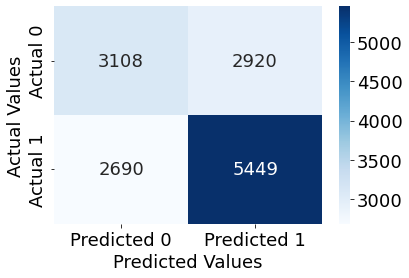

In [84]:
confusion_matrix_train(logit_model_sharedbinboth)